<a href="https://colab.research.google.com/github/ssanchezgoe/curso_deep_learning_economia/blob/main/NBs_Google_Colab/DL_S17_RNN_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

<h1> Curso Deep Learning: Economía</h1>

## S17: Redes neuronales convolucionales y arquitecturas

# Ejemplo: 
Pequeño conjunto de datos de la oficina de estadísticas de Canadá, que corresponde a las ventas minoristas mensuales desde 1991 hasta la actualidad.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ssanchezgoe/curso_deep_learning_economia/main/data/DL_Casim.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


Reorganicemos los datos temporales; para ello realizamos lo siguiente:

1. Convertirmos la columna `Adjustments` en un objeto `to_datetime`.
2. Adicionamos el último día del mes a la cadena mediante el método `MonthEnd(1)`.
3. Fijar la columna `Adjustments` transformada como índice del dataframe.

Veamos el resultado solo de aplicar el método `to_datetime` a los datos


In [3]:
pd.to_datetime(df['Adjustments'])

0     1991-01-01
1     1991-02-01
2     1991-03-01
3     1991-04-01
4     1991-05-01
         ...    
308   2016-09-01
309   2016-10-01
310   2016-11-01
311   2016-12-01
312   2017-01-01
Name: Adjustments, Length: 313, dtype: datetime64[ns]

Si adicionamos el método `MonthEnd(1)`, tenemos:

In [4]:
pd.to_datetime(df['Adjustments'])+MonthEnd(1)

0     1991-01-31
1     1991-02-28
2     1991-03-31
3     1991-04-30
4     1991-05-31
         ...    
308   2016-09-30
309   2016-10-31
310   2016-11-30
311   2016-12-31
312   2017-01-31
Name: Adjustments, Length: 313, dtype: datetime64[ns]

Ahora podemos fijar la columna `Adjustments` como índice del dataframe:

In [5]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


Con la fecha como índice, podemos realizar, fácilmente una gráfica de nuestra serie de tiempo:

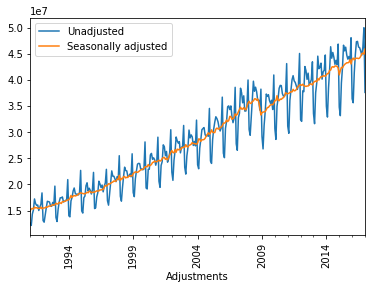

In [6]:
df.plot()
plt.xticks(rotation='vertical')
plt.show()

En esta gráfica puede notarse, perfectamente, la crísis ocurrida en el 2008, como una caida en los datos de la serie.

Cuando se trabaja con una serie de tiempo, es muy importante partir los datos en un conjunto de train y test, respecto a cierta fecha, de tal forma que no se prueben datos que se encuenten antes de los de entranamiento. Para lo anterior, fijamos una fecha para hacer la división:


In [7]:
split_date = pd.Timestamp('01-01-2011')

Trabajaremos sobre la serie no ajustada:

In [8]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

Grafiquemos ambos conjuntos, con el fin de visualizar la secuencialidad de los datos

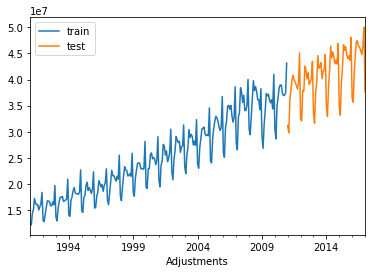

In [9]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

Procedamos a rescalar los datos. Es importante resaltar que cuando se hace una división de train y test y se rescala, se realiza un ajuste y una transformación en los datos de entrenamiento y luego se transforman los datos de test. La razón para esto es que no se debe asumir que se sabe la escala de los datos de test; en este sentido, se transforma todos los datos pero solo se ajusta sobre los datos de entrenamiento.

In [10]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

El proximo paso consiste en definir la variable objetivo como el siguiente punto respecto a cada punto. De esta forma, estaremos construyendo un modelo que, para cierto valor dato, predecirá el siguiente dato.

In [11]:
train_sc[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

## Fully Connected Predictor

In [13]:
K.clear_session()
model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [15]:
history = model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=1, callbacks=[early_stop])

Epoch 1/200
120/120 [==============================] - 1s 1ms/step - loss: 0.0612
Epoch 2/200
120/120 [==============================] - 0s 1ms/step - loss: 0.0201
Epoch 3/200
120/120 [==============================] - 0s 1ms/step - loss: 0.0164
Epoch 4/200
120/120 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 5/200
120/120 [==============================] - 0s 1ms/step - loss: 0.0119
Epoch 6/200
120/120 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 7/200
120/120 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 8/200
120/120 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 9/200
120/120 [==============================] - 0s 953us/step - loss: 0.0100
Epoch 00009: early stopping


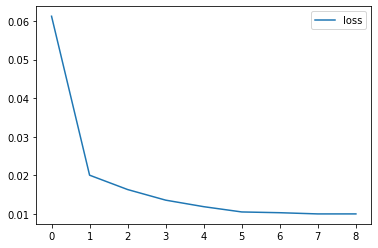

In [16]:
pd.DataFrame(history.history).plot()
plt.show()

Procedamos a realizar una predicción y compararla con los datos originales:

In [17]:
y_pred = model.predict(X_test)

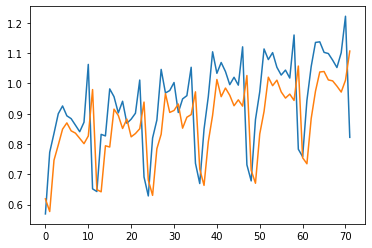

In [18]:
plt.plot(y_test)
plt.plot(y_pred)
plt.show()

Como puede observarse el modelo ajustado no se desempeña adecuadamente, ya que la predicción sufre un corrimiento respecto a los datos.

## Recurrent predictor

Construyamos ahora un predictor recurrente.

Veamos nuestra forma de los datos:

In [19]:
X_train.shape

(239, 1)

No obstante, la celda LSTM requiere de una forma dada por las siguientes dimensiones (batch_size, timesteps, input_dim), por lo que debemos realizar el siguiente resize:

In [20]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train.reshape(len(X_train),1,1).shape

(239, 1, 1)

In [21]:
X_train_t = X_train.reshape(len(X_train),1,1)
X_test_t = X_test.reshape(len(X_test),1,1)

In [22]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.fit(X_train_t, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 2s 2ms/step - loss: 0.1509
Epoch 2/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0551
Epoch 3/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0432
Epoch 4/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 5/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0287
Epoch 6/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 7/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 8/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 9/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 10/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 11/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 12/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 13/100


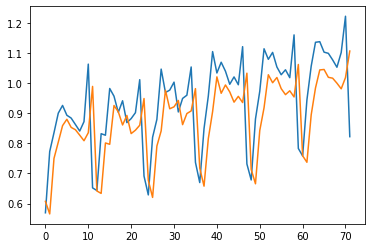

In [24]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)
plt.show()

# Metodo de la ventana 

In [25]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [27]:
train_sc_df

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-08-31,0.814394,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290,0.773687,0.754447,0.770968
2010-09-30,0.799167,0.814394,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290,0.773687,0.754447
2010-10-31,0.802101,0.799167,0.814394,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290,0.773687


In [28]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [31]:
X_train.shape

(228, 12)

Creación de los arreglos de numpy

In [32]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

## Fully connected

In [33]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 1s 1ms/step - loss: 0.1146
Epoch 2/200
228/228 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 3/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 4/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 5/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 6/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 7/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 8/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 9/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 10/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 11/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 12/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 13/200


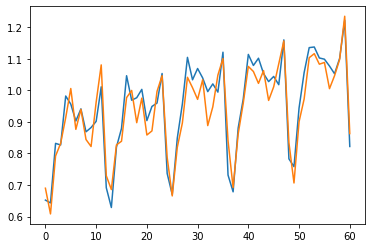

In [35]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

LSTM con ventana

In [36]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [37]:
X_train_t.shape

(228, 1, 12)

In [38]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 456       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 2s 2ms/step - loss: 0.0318
Epoch 2/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 3/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 4/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 5/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 6/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 7/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 8/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 9/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 10/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 11/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 12/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 13/100


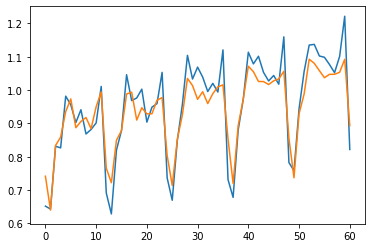

In [41]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)